# CS 437 - Deep Learning - Assignment 4

*__Submission Instructions:__*
- Rename this notebook to `hw4_rollnumber.ipynb` before submission on LMS.
- Code for all the tasks must be written in this notebook (you do not need to submit any other files).
- The output of all cells must be present in the version of the notebook you submit.
- The university honor code should be maintained. Any violation, if found, will result in disciplinary action. 

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from keras.models import load_model
from keras.applications import vgg16
from keras.utils import plot_model, to_categorical
from keras.optimizers import Adam
from keras.layers import Flatten, Dense, Dropout, Input, Conv1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib


from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import csv
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import random

import scipy
from scipy.spatial.distance import cdist
import numpy as np

import os
your_id = 20110126

Using TensorFlow backend.


## Overview

In this assignment you will be exploring a few important concepts used in the deep learning projects:
- Working with satellite imagery data
- Dataset annotation
- Fine-tuning / Transfer Learning
- Unsupervised feature representation with Autoencoder
- Comparison of end-to-end trained model with finetuned model

We will be using two datasets, the links are provided to you. You will also be working with three pretrained models, which have been provided to you. You are **highly** encouraged to explore the datasets and model architectures in order to get the most out of this assignment. 

**_Datasets:_**
- Brick Kiln (Nepal) - available [here](https://drive.google.com/drive/folders/1dQEA0fxepVnELPnz-gAAYFb9hJSV4Azc)
- UC Merced Land Use - available [here](http://weegee.vision.ucmerced.edu/datasets/landuse.html)

**_Pretrained Models:_** 
Can be found [here](https://drive.google.com/open?id=1Ekvk3JUW3eI5sgITxzNklXrJXnCfTKBu)
- ResNet18 pretrained on Brick Kiln (Lahore) - available as `InceptionResNet-v2-2classes`
- Autoencoder pretrained on GT Cross View and fine tuned on UC Merced - available as `encoder_gt`
- VGG16 pretrained on ImageNet - available in `keras.applications` (consult relevant documentation)

In [2]:
batch_size = 16
num_classes = 2
input_shape = (224,224,3)
nepal_mainDir = 'Data/Nepal_Brick_Kilns/'
dir_no_kilns_nepal = 'Data/Nepal_Brick_Kilns/NoKilns/'
dir_kilns_nepal = 'Data/Nepal_Brick_Kilns/Kilns/'

## Task 1

Let's start with a binary classification problem. 

The Brick Kiln (Nepal) dataset you have been given consists of 100 tiles at zoom level 17. A script to break up these tiles into 64 sub-tiles of zoom 20 has also been given to you. Your job is to:
- Split 100 images into 6400 images using the script
- Manually annotate the dataset by moving the kiln pictures into one folder and non-kiln picutures into other folder.
- Code up a generator to properly load the images and corresponding binary labels into a model. You have to resize images into 224X224X3

*Scale images between 0 and 1 and apply mean subtraction in the generator*

*Each of you has been given unique 100 tiles, so for the love of God do not get annotated data from someone else.*

In [3]:
paths_to_folders = os.listdir(nepal_mainDir)

In [4]:
paths_to_folders = os.listdir(nepal_mainDir)
labels_total = [] #each index contains paths to one class
paths_to_images = []  #each index contains labels to one class

for i in range(len(paths_to_folders)): #completing path
    paths_to_folders[i] = nepal_mainDir + paths_to_folders[i]
paths_to_folders = paths_to_folders[1:]

for i in range(len(paths_to_folders)):
    paths_to_images.append(os.listdir(paths_to_folders[i]))
    
for i in range(len(paths_to_images)):
    l = []
    for j in range(len(paths_to_images[i])):
        paths_to_images[i][j] = paths_to_folders[i] + '/' + paths_to_images[i][j]
        l.append(i)
    labels_total.append(l)
        
        

In [5]:
input_train ,input_test, label_train, label_test = [],[],[],[]
input_val, label_val = [],[]

for i in range(len(paths_to_images)):
    x_train ,x_test, y_train, y_test = train_test_split(paths_to_images[i], labels_total[i], test_size=0.2)
    input_train.append(x_train)
    input_test.append(x_test)
    label_train.append(y_train)
    label_test.append(y_test)

x  = input_train
y = label_train
input_train, label_train = [],[]

for i in range(len(x)):
    x_train ,x_val, y_train, y_val = train_test_split(x[i], y[i], test_size=0.1)
    input_train.append(x_train)
    input_val.append(x_val)
    label_train.append(y_train)
    label_val.append(y_val)  

In [6]:
input_train_for_generator = []
input_val_for_generator = []
input_test_for_generator = []
label_train_for_generator = []
label_val_for_generator = []
label_test_for_generator = []

for i in range(len(input_val)):
    for j in range(len(input_val[i])):
        input_val_for_generator.append(input_val[i][j])
        label_val_for_generator.append(label_val[i][j])
        
for i in range(len(input_test)):
    for j in range(len(input_test[i])):
        input_test_for_generator.append(input_test[i][j])
        label_test_for_generator.append(label_test[i][j])
        
for i in range(len(input_train)):
    for j in range(len(input_train[i])):
        input_train_for_generator.append(input_train[i][j])
        label_train_for_generator.append(label_train[i][j])

#randomly shuffling data before sending into generator    
c = list(zip(input_val_for_generator, label_val_for_generator))
random.shuffle(c)
input_val_for_generator, label_val_for_generator = zip(*c)


c = list(zip(input_test_for_generator, label_test_for_generator))
random.shuffle(c)
input_test_for_generator, label_test_for_generator = zip(*c)

c = list(zip(input_train_for_generator, label_train_for_generator))
random.shuffle(c)
input_train_for_generator, label_train_for_generator = zip(*c)

In [7]:
print ("Total Images for training: ", len(label_train_for_generator))
print ("Total Images for validation: ", len(label_val_for_generator))
print ("Total Images for testing: ", len(label_test_for_generator))
print ("Total Images for testing: ", len(input_test_for_generator)+len(input_train_for_generator)+len(input_val_for_generator))

Total Images for training:  5482
Total Images for validation:  610
Total Images for testing:  1524
Total Images for testing:  7616


In [24]:
def brick_kiln_generator(path_images, y_labels, batch_size = 16, processing = False):
    total_pictures = len(path_images)
    #print (total_pictures)
    indexes = np.arange(0,total_pictures,batch_size) #setting start index of each batch
    
    if total_pictures % batch_size != 0:
        indexes = indexes[:-1]  #dropping last index if last batch does not complete the batch size requirement
    #print (len(indexes))

    while True:
        np.random.shuffle(indexes) #shuffles indexes so order of data given to model in each loop is different
        for index in indexes:
            path = path_images[index : index + batch_size]
            labels = y_labels[index : index + batch_size]
            labels_categorical = to_categorical(labels, num_classes=2)
            
            x_array = np.zeros((batch_size,256,256,3))

            for i in range(batch_size):
                img = cv2.imread(path[i])
                x_array[i] = cv2.resize(img,(256,256))
            
            if processing == True:
                x_array = x_array/255.0
                x_array = x_array - np.mean(x_array)

            batch_x = x_array
            batch_y = np.array(labels_categorical)
            yield batch_x, batch_y
            

In [9]:
train_generator_task1 = brick_kiln_generator(input_train_for_generator, label_train_for_generator)
val_generator_task1 = brick_kiln_generator(input_val_for_generator, label_val_for_generator)
test_generator_task1 = brick_kiln_generator(input_test_for_generator, label_test_for_generator)

In [38]:
model_name = ' '

In [39]:
checkpoint = ModelCheckpoint('Best_models/' + model_name + '-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

callbacks = [checkpoint]

## Task 2

Now you will evaluate performance of a pretrained (on Brick Kiln Lahore dataset) ResNet18 model using the generator made in Task1. You will:
- Obtain predictions for the entire dataset
- Construct a binary confusion matrix and visualize it as a heatmap

*You can use scikit-learn's `metrics.confusion_matrix` function. Consult the relevant documentation.*

##### Using data sent by TA on mail

In [2]:
dir_task2_test = 'task2_test/'

In [3]:
folders_paths = os.listdir(dir_task2_test)
labels_test = [] #each index contains paths to one class
image_paths = []  #each index contains labels to one class

folders_paths = folders_paths[0:1] + folders_paths[2:] #removing .DS folder

for i in range(len(folders_paths)): #completing path
    folders_paths[i] = dir_task2_test + folders_paths[i]

for i in range(len(folders_paths)):
    image_paths.append(os.listdir(folders_paths[i]))
    
for i in range(len(image_paths)):
    l = []
    for j in range(len(image_paths[i])):
        image_paths[i][j] = folders_paths[i] + '/' + image_paths[i][j]
        l.append(i)
    labels_test.append(l)
        
        

In [4]:
input_task2_testing = []
labels_task2_testing = []

counter = 0
for i in range(len(image_paths)):
    for j in range(len(image_paths[i])):
        input_task2_testing.append(image_paths[i][j])
        labels_task2_testing.append(counter)  
    counter += 1

In [5]:
testing_images = np.zeros((len(input_task2_testing),256,256,3))
for i in range(len(input_task2_testing)):
    testing_images[i] = cv2.imread(input_task2_testing[i])
testing_labels = to_categorical(labels_task2_testing, num_classes=2)

In [71]:
lahore_ResNet18 = load_model('Lahore_Model/InceptionResNet-v2-2classes.h5')

In [11]:
lahore_ResNet18.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

batch_normalization_177 (BatchN (None, 6, 6, 192)    576         conv2d_177[0][0]                 
__________________________________________________________________________________________________
activation_177 (Activation)     (None, 6, 6, 192)    0           batch_normalization_177[0][0]    
__________________________________________________________________________________________________
conv2d_178 (Conv2D)             (None, 6, 6, 224)    129024      activation_177[0][0]             
__________________________________________________________________________________________________
batch_normalization_178 (BatchN (None, 6, 6, 224)    672         conv2d_178[0][0]                 
__________________________________________________________________________________________________
activation_178 (Activation)     (None, 6, 6, 224)    0           batch_normalization_178[0][0]    
__________________________________________________________________________________________________
conv2d_176

In [67]:
testing_images.shape

(28, 256, 256, 3)

In [8]:
pred_task2 = lahore_ResNet18.predict(testing_images,verbose = 1)

28/28 [==============================] - 31s 1s/step


In [9]:
cm_task2 = confusion_matrix(testing_labels.argmax(axis=1), pred_task2.argmax(axis=1))
cm_task2

array([[13,  1],
       [ 0, 14]])

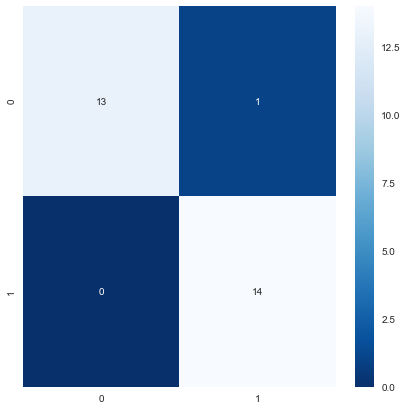

In [7]:
plt.figure(figsize=(7,7))
sns.heatmap(cm_task2 ,annot = True, cmap = "Blues_r")

## Task 3

Next you will employ Transfer Learning and finetune the pretrained ResNet18 model you used in Task2 to better fit the Brick Kiln (Nepal) dataset. You will:
- Freeze everything except the FC layers and train it using the generator from Task1 (using appropriate hyperparameters)
- Construct a binary confusion matrix and visualize it as a heatmap
- Compare this confusion matrix with the one made in Task2

In [12]:
for layer in lahore_ResNet18.layers[:-1]:
    layer.trainable = False

adam = Adam(lr=0.001)
lahore_ResNet18.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])
lahore_ResNet18.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

activation_35 (Activation)      (None, 29, 29, 48)   0           batch_normalization_35[0][0]     
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 29, 29, 32)   10240       block35_3_ac[0][0]               
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 29, 29, 32)   9216        activation_32[0][0]              
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 29, 29, 64)   27648       activation_35[0][0]              
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 29, 29, 32)   96          conv2d_31[0][0]                  
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________
conv2d_153 (Conv2D)             (None, 14, 14, 192)  208896      block17_19_ac[0][0]              
__________________________________________________________________________________________________
conv2d_156 (Conv2D)             (None, 14, 14, 192)  215040      activation_155[0][0]             
__________________________________________________________________________________________________
batch_normalization_153 (BatchN (None, 14, 14, 192)  576         conv2d_153[0][0]                 
__________________________________________________________________________________________________
batch_normalization_156 (BatchN (None, 14, 14, 192)  576         conv2d_156[0][0]                 
__________________________________________________________________________________________________
activation_153 (Activation)     (None, 14, 14, 192)  0           batch_normalization_153[0][0]    
__________

batch_normalization_200 (BatchN (None, 6, 6, 192)    576         conv2d_200[0][0]                 
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 6, 6, 256)    768         conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_200 (Activation)     (None, 6, 6, 192)    0           batch_normalization_200[0][0]    
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 6, 6, 256)    0           batch_normalization_203[0][0]    
__________________________________________________________________________________________________
block8_10_mixed (Concatenate)   (None, 6, 6, 448)    0           activation_200[0][0]             
                                                                 activation_203[0][0]             
__________

In [14]:
train_generator_task1 = brick_kiln_generator(input_train_for_generator, label_train_for_generator)
val_generator_task1 = brick_kiln_generator(input_val_for_generator, label_val_for_generator)

In [15]:
model_name = 'task3_trained'

task3_train = lahore_ResNet18.fit_generator(train_generator_task1, 
                                     epochs=10, 
                                     steps_per_epoch=len(label_train_for_generator)//batch_size,
                                     validation_data= val_generator_task1,
                                     validation_steps=len(label_val_for_generator)//batch_size, 
                                     callbacks=callbacks, verbose=1)

#10 epochs = 8 hours
lahore_ResNet18.save(model_name + '.h5')

Epoch 1/10
342/342 [==============================] - 2014s 6s/step - loss: 0.2207 - acc: 0.9748 - val_loss: 0.0972 - val_acc: 0.9918
Epoch 2/10
342/342 [==============================] - 60321s 176s/step - loss: 0.1196 - acc: 0.9925 - val_loss: 0.0757 - val_acc: 0.9918
Epoch 3/10
342/342 [==============================] - 2098s 6s/step - loss: 0.0928 - acc: 0.9923 - val_loss: 0.0587 - val_acc: 0.9918
Epoch 4/10
342/342 [==============================] - 6231s 18s/step - loss: 0.0247 - acc: 0.9934 - val_loss: 0.0723 - val_acc: 0.9918
Epoch 5/10
342/342 [==============================] - 1972s 6s/step - loss: 0.0198 - acc: 0.9940 - val_loss: 0.0875 - val_acc: 0.9918
Epoch 6/10
342/342 [==============================] - 2041s 6s/step - loss: 0.0183 - acc: 0.9943 - val_loss: 0.0886 - val_acc: 0.9918
Epoch 7/10
342/342 [==============================] - 2033s 6s/step - loss: 0.0191 - acc: 0.9952 - val_loss: 0.1095 - val_acc: 0.9918
Epoch 8/10
342/342 [==============================] - 2046

In [25]:
test_generator_task1 = brick_kiln_generator(input_test_for_generator, label_test_for_generator)
#94 iterations

predictions_task3 = []
actual_values_task3 = []
for i in range(len(y_test)//batch_size):
    x, y = next(test_generator_task1)
    print(i)
    pred = lahore_ResNet18.predict(x,verbose = 1)
    actual_values_task3.append(y)
    predictions_task3.append(pred)
    

0
16/16 [==============================] - 6s 345ms/step
1
16/16 [==============================] - 6s 353ms/step
2
16/16 [==============================] - 5s 343ms/step
3
16/16 [==============================] - 6s 375ms/step
4
16/16 [==============================] - 6s 371ms/step
5
16/16 [==============================] - 5s 343ms/step
6
16/16 [==============================] - 6s 369ms/step
7
16/16 [==============================] - 6s 359ms/step
8
16/16 [==============================] - 6s 360ms/step
9
16/16 [==============================] - 5s 334ms/step
10
16/16 [==============================] - 5s 330ms/step
11
16/16 [==============================] - 5s 331ms/step
12
16/16 [==============================] - 6s 375ms/step
13
16/16 [==============================] - 7s 410ms/step
14
16/16 [==============================] - 8s 470ms/step
15
16/16 [==============================] - 7s 429ms/step
16
16/16 [==============================] - 7s 442ms/step
17
16/16 [==============

In [28]:
preds_total_task3 = []
labels_total_task3 = []

for epoch in predictions_task3:
    for val in epoch:
        preds_total_task3.append(val)
        
for epoch in actual_values_task3:
    for val in epoch:
        labels_total_task3.append(val)        

preds_total_task3 = np.array(preds_total_task3)
labels_total_task3 = np.array(labels_total_task3)       

In [29]:
cm_task3 = confusion_matrix(labels_total_task3.argmax(axis=1), preds_total_task3.argmax(axis=1))
cm_task3

array([[1508,    0],
       [  12,    0]])

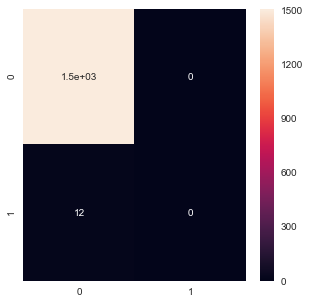

In [16]:
plt.figure(figsize=(5,5))
sns.heatmap(cm_task3, annot = True)

## Task 4

Now we will look at a multiclass classification problem.

The UC Merced Land Use dataset consists of 21 classes, ranging from airplanes to forests to tennis courts. Let's add kilns to it since you worked so hard to annotate the dataset in Task1. You will:
- Download the dataset and add a new folder (following the already existing folder structure) corresponding to brick kilns
- Code up a generator to properly load the images and corresponding 22-class labels into a model. You have to resize images into 224X224X3 for VGG16

*Scale images between 0 and 1 and apply mean subtraction in the generator*

In [2]:
batch_size = 64
num_classes = 22
input_shape = (224,224,3)
dir_main_landuse = 'Data/LandUseDataset/Images/'

In [6]:
paths_to_folders = os.listdir(dir_main_landuse)
labels_total = [] #each index contains paths to one class
paths_to_images = []  #each index contains labels to one class

for i in range(len(paths_to_folders)): #completing path
    paths_to_folders[i] = dir_main_landuse + paths_to_folders[i]
    
# paths_to_folders = paths_to_folders[0:4] + paths_to_folders[5:]  #removing .DS folder
paths_to_folders = paths_to_folders[1:]

for i in range(len(paths_to_folders)):
    paths_to_images.append(os.listdir(paths_to_folders[i]))
    
for i in range(len(paths_to_images)):
    l = []
    for j in range(len(paths_to_images[i])):
        paths_to_images[i][j] = paths_to_folders[i] + '/' + paths_to_images[i][j]
        l.append(i)
    labels_total.append(l)
        
        

In [7]:
input_train ,input_test, label_train, label_test = [],[],[],[]
input_val, label_val = [],[]

for i in range(len(paths_to_images)):
    x_train ,x_test, y_train, y_test = train_test_split(paths_to_images[i], labels_total[i], test_size=0.2)
    input_train.append(x_train)
    input_test.append(x_test)
    label_train.append(y_train)
    label_test.append(y_test)

x  = input_train
y = label_train
input_train, label_train = [],[]

for i in range(len(x)):
    x_train ,x_val, y_train, y_val = train_test_split(x[i], y[i], test_size=0.1)
    input_train.append(x_train)
    input_val.append(x_val)
    label_train.append(y_train)
    label_val.append(y_val)  

In [8]:
input_train_for_generator = []
input_val_for_generator = []
input_test_for_generator = []
label_train_for_generator = []
label_val_for_generator = []
label_test_for_generator = []

for i in range(len(input_val)):
    for j in range(len(input_val[i])):
        input_val_for_generator.append(input_val[i][j])
        label_val_for_generator.append(label_val[i][j])
        
for i in range(len(input_test)):
    for j in range(len(input_test[i])):
        input_test_for_generator.append(input_test[i][j])
        label_test_for_generator.append(label_test[i][j])
        
for i in range(len(input_train)):
    for j in range(len(input_train[i])):
        input_train_for_generator.append(input_train[i][j])
        label_train_for_generator.append(label_train[i][j])

#randomly shuffling data before sending into generator
c = list(zip(input_val_for_generator, label_val_for_generator))
random.shuffle(c)
input_val_for_generator, label_val_for_generator = zip(*c)


c = list(zip(input_test_for_generator, label_test_for_generator))
random.shuffle(c)
input_test_for_generator, label_test_for_generator = zip(*c)

c = list(zip(input_train_for_generator, label_train_for_generator))
random.shuffle(c)
input_train_for_generator, label_train_for_generator = zip(*c)

In [9]:
print ("Total Images for training: ", len(input_train_for_generator))
print ("Total Images for validation: ", len(input_val_for_generator))
print ("Total Images for testing: ", len(input_test_for_generator))

Total Images for training:  1554
Total Images for validation:  173
Total Images for testing:  432


In [10]:
def land_use_generator(path_all_images, class_labels, batch_size = 64):
    total_pictures = len(path_all_images)
    indexes = np.arange(0,total_pictures,batch_size) #setting start index of each batch
    
    if total_pictures % batch_size != 0:
        indexes = indexes[:-1]  #dropping last index if last batch does not complete the batch size requirement
        
    while True:
        np.random.shuffle(indexes) #shuffles indexes so order of data given to model in each epoch is different
        for index in indexes:
            path = path_all_images[index : index + batch_size]
            labels = class_labels[index : index + batch_size]
            
            x_array = np.zeros((batch_size,224,224,3))
            batch_labels = to_categorical(labels, num_classes = 22)
            
            for i in range(batch_size):
                img = cv2.imread(path[i])
                x_array[i] = cv2.resize(img,(224,224))
                
            x_array = x_array.astype('float32')/255.0
                
            batch_x = x_array  
            batch_y = np.array(batch_labels)
            yield batch_x, batch_y
    

## Task 5

Next you will again employ Transfer Learning and finetune the pretrained (on ImageNet) VGG16 to better fit the modified Land Use dataset. You will:
- Change the number of nodes in the last FC layer according to the number of classes i.e. 22 
- Freeze everything except the FC layers and train it using the generator from Task4 (using appropriate hyperparameters)
- Construct a multi-class confusion matrix and visualize it as a heatmap

In [34]:
vgg_imagenet = vgg16.VGG16(include_top=False, weights='imagenet')
for l in vgg_imagenet.layers:
    l.trainable = False

im =  Input(shape=(224,224,3))
vgg = vgg_imagenet(im)
flat = Flatten()(vgg)
# fc2 = Dense(1024, activation='relu')(flat)
# dropout2 = Dropout(0.2)(fc2)
output = Dense(num_classes, activation='softmax')(flat)

my_model = Model(im,output)

my_model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.00001), 
              metrics=['accuracy'])
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 22)                551958    
Total params: 15,266,646
Trainable params: 551,958
Non-trainable params: 14,714,688
_________________________________________________________________


In [35]:
train_generator_task4 = land_use_generator(input_train_for_generator, label_train_for_generator)
val_generator_task4 = land_use_generator(input_val_for_generator, label_val_for_generator)

In [40]:
model_name = 'task5_trained2'

task5_train2 = my_model.fit_generator(train_generator_task4, 
                                     epochs=25, 
                                     steps_per_epoch=len(label_train_for_generator)//batch_size,
                                     validation_data= val_generator_task4,
                                     validation_steps=len(label_val_for_generator)//batch_size, 
                                     callbacks=callbacks, verbose=1)
  
#2.5 hours per 10 epochs
my_model.save(model_name + '.h5')

Epoch 1/25
24/24 [==============================] - 766s 32s/step - loss: 3.2352 - acc: 0.0482 - val_loss: 3.0573 - val_acc: 0.0781

Epoch 00001: val_loss improved from inf to 3.05729, saving model to Best_models/ -01-3.06.h5
Epoch 2/25
24/24 [==============================] - 710s 30s/step - loss: 2.9702 - acc: 0.1120 - val_loss: 2.8721 - val_acc: 0.2109

Epoch 00002: val_loss improved from 3.05729 to 2.87209, saving model to Best_models/ -02-2.87.h5
Epoch 3/25
24/24 [==============================] - 707s 29s/step - loss: 2.7820 - acc: 0.2311 - val_loss: 2.7187 - val_acc: 0.3359

Epoch 00003: val_loss improved from 2.87209 to 2.71865, saving model to Best_models/ -03-2.72.h5
Epoch 4/25
24/24 [==============================] - 804s 34s/step - loss: 2.6159 - acc: 0.3757 - val_loss: 2.5749 - val_acc: 0.4375

Epoch 00004: val_loss improved from 2.71865 to 2.57494, saving model to Best_models/ -04-2.57.h5
Epoch 5/25
24/24 [==============================] - 721s 30s/step - loss: 2.4681 - a

In [10]:
my_model = load_model('task5_trained2.h5')

In [11]:
test_generator_task4 = land_use_generator(input_test_for_generator, label_test_for_generator)

predictions_task5 = []
actual_values_task5 = []
for i in range(len(input_test_for_generator)//batch_size):
    x, y = next(test_generator_task4)
    print(i)
    pred = my_model.predict(x ,verbose = 1)
    actual_values_task5.append(y)
    predictions_task5.append(pred)
    

0
32/32 [==============================] - 14s 450ms/step
1
32/32 [==============================] - 13s 412ms/step
2
32/32 [==============================] - 13s 412ms/step
3
32/32 [==============================] - 13s 413ms/step
4
32/32 [==============================] - 13s 412ms/step
5
32/32 [==============================] - 14s 422ms/step
6
32/32 [==============================] - 13s 416ms/step
7
32/32 [==============================] - 13s 417ms/step
8
32/32 [==============================] - 13s 414ms/step
9
32/32 [==============================] - 13s 414ms/step
10
32/32 [==============================] - 13s 411ms/step
11
32/32 [==============================] - 13s 412ms/step
12
32/32 [==============================] - 13s 413ms/step


In [12]:
preds_total_task5 = []
labels_total_task5 = []

for epoch in predictions_task5:
    for val in epoch:
        preds_total_task5.append(val)
        
for epoch in actual_values_task5:
    for val in epoch:
        labels_total_task5.append(val)        

preds_total_task5 = np.array(preds_total_task5)
labels_total_task5 = np.array(labels_total_task5)       

In [13]:
cm_task5 = confusion_matrix(labels_total_task5.argmax(axis=1), preds_total_task5.argmax(axis=1))
cm_task5

array([[19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0],
       [ 0, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0],
       [ 0,  0, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1,  0,  0],
       [ 0,  0,  0, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0, 19,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 18,  0,  0,

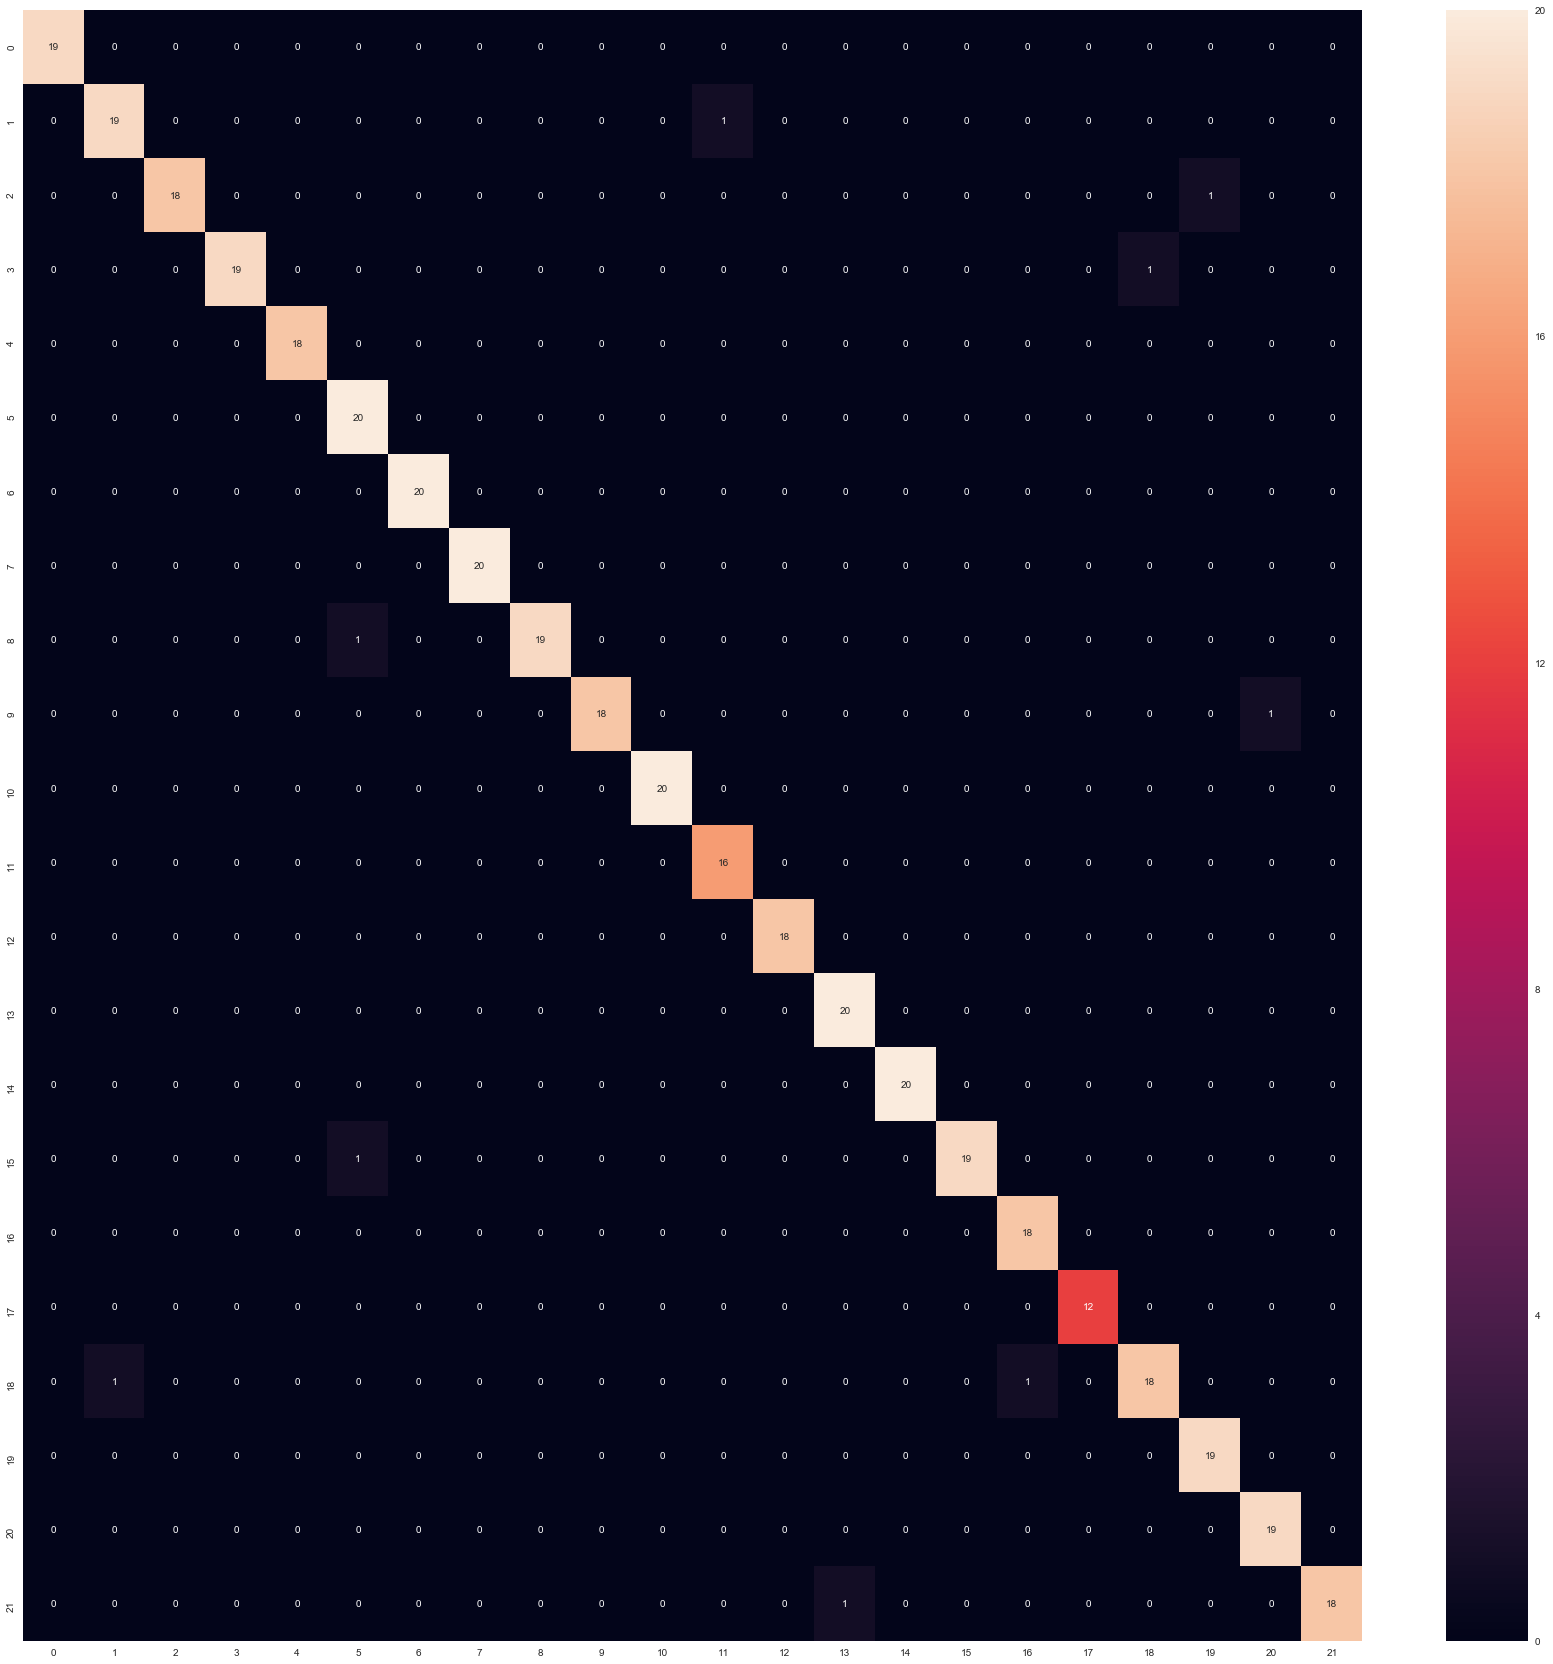

In [12]:
plt.figure(figsize=(30,30))
sns.heatmap(cm_task5, annot = True)

## Task 6

Now you will make use of Unsupervised Representation Learning as studied in class. You have been provided with a pretrained autoencoder (just the encoder part) and you will use it to obtain deep features for the modified UC Merced Land Use dataset. You will have to:
- Obtain predictions for the entire dataset
- Save then in an appropriate fashion

*Keep in mind that this model takes input of shape 256X256X3 so you need to resize the images before feeding them into this model*

*Try to think about how you could use the generator from Task4 to create another generator which would yield encoded features along with labels instead of raw images*

In [41]:
batch_size = 64

In [11]:
encoder_pretained = load_model('encoder_gt.h5')
encoder_pretained.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001), 
              metrics=['accuracy'])
encoder_pretained.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 20) 2960        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 20) 80          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 20) 0           batch_normalization_1[0][0]      
_____________________________________

C:\Users\admin\Anaconda3\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [12]:
def encoder_generator(path_all_images, class_labels, batch_size = 64):
    total_pictures = len(path_all_images)
    
    indexes = np.arange(0,total_pictures,batch_size) #setting start index of each batch
    
    if total_pictures % batch_size != 0:
        indexes = indexes[:-1]  #dropping last index if last batch does not complete the batch size requirement

    while True:
        np.random.shuffle(indexes) #shuffles indexes so order of data given to model in each epoch is different
        for index in indexes:
            path = path_all_images[index : index + batch_size]
            labels = class_labels[index : index + batch_size]
            
            x_array = np.zeros((batch_size,256,256,3))
            batch_labels = to_categorical(labels, num_classes = 22)
            
            for i in range(batch_size):
                img = cv2.imread(path[i])
                x_array[i] = cv2.resize(img,(256,256))
                
            resized_images = x_array  
            labels = np.array(batch_labels)
            
            encoded_output = encoder_pretained.predict(resized_images,verbose=0)
            encoded_output_reshaped = np.reshape(encoded_output, (encoded_output.shape[0],
                                                                 encoded_output.shape[1]*encoded_output.shape[2],
                                                                 encoded_output.shape[3]))
        
            yield encoded_output_reshaped, labels
        

In [13]:
paths_to_all_images_task6 = []
labels_to_all_images_task6 = []

for i in range(len(paths_to_images)):
    for j in range(len(paths_to_images[i])):
        paths_to_all_images_task6.append(paths_to_images[i][j])
        labels_to_all_images_task6.append(labels_total[i][j])

In [15]:
gen_task6 = encoder_generator(paths_to_all_images_task6, labels_to_all_images_task6)

In [47]:
encoded_predictions_task6 = []
labels_encoded_predictions_task6 = []

#33 iterations
for i in range(len(paths_to_all_images_task6)//batch_size):
    gen = next(gen_task6)
    encoded_predictions_task6.append(gen[0])
    labels_encoded_predictions_task6.append(gen[1])
    

In [51]:
encoded_predictions_task6 = []
labels_encoded_predictions_task6 = []

#33 iterations
for i in range(len(paths_to_all_images_task6)//batch_size):
    gen = next(gen_task6)
    encoded_predictions_task6.append(gen[0])
    labels_encoded_predictions_task6.append(gen[1])
    

64/64 [==============================] - 18s 286ms/step


## Task 7

Now you will train a classifier from scratch to discriminate the 22 classes based on the deep features you extracted in Task6. You will:
- Train a classifier with the following architecture
> 1D conv 3x1 -> 1D conv 3x1 -> FC 256 -> FC 22
- Construct a multiclass confusion matrix and visualize it as a heatmap
- Compare this confusion matrix with the one made in Task5

*The input to this model will be the deep feature tensor obtained in Task6, so use appropriate input shape*

In [34]:
batch_size = 64

In [23]:
x_train_task7 = input_train_for_generator
x_val_task7 = input_val_for_generator 
x_test_task7 = input_test_for_generator 
y_train_task7 = label_train_for_generator
y_val_task7 = label_val_for_generator 
y_test_task7 = label_test_for_generator 

print ("Training samples: ", len(x_train_task7))
print ("Validation samples: ", len(x_val_task7))
print ("Testing samples: ", len(x_test_task7))
print ("Testing samples: ", len(y_test_task7) + len(y_val_task7) + len(y_train_task7))

Training samples:  1554
Validation samples:  173
Testing samples:  432
Testing samples:  2159


In [24]:
input_shape = (64,20)
#  --> input shape is chosen as 64,20 
#  --> 20 is the number of channels (features) which will remain the same at the input layer
#  --> we get 60 by multiplying the rows and columns (8*8 = 64). This we we are able to use all
#  the data from image and we also get a 2D tensor, which is needed in order to run a 1D conv


input_im = Input(shape=(input_shape), name='input_im')
conv1 = Conv1D(100,1)(input_im)
conv2 = Conv1D(100,1)(conv1)
flat = Flatten()(conv2)
dense1 = Dense(256, activation='relu')(flat)
output_class = Dense(22, activation='softmax')(dense1)

decoder_model = Model(inputs=input_im, outputs=output_class)

decoder_model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.0001), 
              metrics=['accuracy'])

decoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 64, 20)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 100)           2100      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 64, 100)           10100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1638656   
_________________________________________________________________
dense_2 (Dense)              (None, 22)                5654      
Total params: 1,656,510
Trainable params: 1,656,510
Non-trainable params: 0
_________________________________________________________________


In [28]:
train_gen_task7 = encoder_generator(x_train_task7, y_train_task7)
val_gen_task7 = encoder_generator(x_val_task7, y_val_task7)

In [235]:
#training 3
# 100 filters + lr = 0.0001
model_name = 'decoder_task7_2'

task7_train2 = decoder_model.fit_generator(train_gen_task7, epochs=30,
                                          steps_per_epoch=len(y_train_task7)//batch_size,
                                          validation_data=val_gen_task7,
                                          validation_steps=len(y_val_task7)//batch_size,
                                          callbacks=callbacks, verbose=1)

decoder_model.save(model_name + '.h5')

Epoch 1/20
24/24 [==============================] - 475s 20s/step - loss: 4.5610 - acc: 0.0495 - val_loss: 3.3190 - val_acc: 0.0781
Epoch 2/20
24/24 [==============================] - 428s 18s/step - loss: 3.1444 - acc: 0.0658 - val_loss: 3.0884 - val_acc: 0.1094
Epoch 3/20
24/24 [==============================] - 426s 18s/step - loss: 3.0219 - acc: 0.1152 - val_loss: 3.0029 - val_acc: 0.0625
Epoch 4/20
24/24 [==============================] - 431s 18s/step - loss: 2.9004 - acc: 0.1374 - val_loss: 2.9346 - val_acc: 0.0938
Epoch 5/20
24/24 [==============================] - 443s 18s/step - loss: 2.7841 - acc: 0.1888 - val_loss: 2.9108 - val_acc: 0.1250
Epoch 6/20
24/24 [==============================] - 578s 24s/step - loss: 2.7116 - acc: 0.2142 - val_loss: 2.8979 - val_acc: 0.1484
Epoch 7/20
24/24 [==============================] - 429s 18s/step - loss: 2.6443 - acc: 0.2298 - val_loss: 2.7660 - val_acc: 0.1641
Epoch 8/20
24/24 [==============================] - 432s 18s/step - loss: 2.

In [13]:
decoder_ = load_model(('decoder_task7_2.h5'))

In [37]:
train_gen_task7 = encoder_generator(x_train_task7, y_train_task7, batch_size)
val_gen_task7 = encoder_generator(x_val_task7, y_val_task7, batch_size)

In [39]:
#Further training, 10 more epochs
epoch_ = 10
for i in range(epoch_):
    for i in range(len(y_train_task7)//batch_size):
        x,y = next(train_gen_task7)
        decoder_.train_on_batch(x,y)

In [40]:
test_gen_task7 = encoder_generator(x_test_task7, y_test_task7)

predictions_task7 = []
actual_values_task7 = []

#6 iterations
for i in range(len(x_test_task7)//batch_size):
    x, y = next(test_gen_task7)
    print(i)
    pred = decoder_.predict(x ,verbose = 1)
    actual_values_task7.append(y)
    predictions_task7.append(pred)

0
64/64 [==============================] - 0s 6ms/step
1
64/64 [==============================] - 0s 396us/step
2
64/64 [==============================] - 0s 303us/step
3
64/64 [==============================] - 0s 254us/step
4
64/64 [==============================] - 0s 267us/step
5
64/64 [==============================] - 0s 254us/step


In [41]:
preds_total_task7 = []
labels_total_task7 = []

for epoch in predictions_task7:
    for val in epoch:
        preds_total_task7.append(val)
        
for epoch in actual_values_task7:
    for val in epoch:
        labels_total_task7.append(val)        

preds_total_task7 = np.array(preds_total_task7)
labels_total_task7 = np.array(labels_total_task7)       

In [42]:
cm_task7 = confusion_matrix(labels_total_task7.argmax(axis=1), preds_total_task7.argmax(axis=1))
cm_task7

array([[11,  0,  1,  0,  0,  0,  0,  0,  0,  2,  0,  2,  0,  0,  0,  0,
         0,  2,  0,  0,  0,  0],
       [ 0,  5,  0,  0,  0,  1,  0,  0,  2,  1,  0,  0,  0,  3,  2,  2,
         0,  0,  0,  0,  0,  3],
       [ 3,  0,  6,  0,  1,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  1,
         0,  2,  0,  2,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  0,  0,  1,  4,  2,  3,  0,  0,  0,  0,
         1,  0,  0,  2,  0,  3],
       [ 0,  0,  1,  0,  9,  0,  1,  0,  0,  3,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1,  2,  1],
       [ 0,  0,  1,  0,  0,  6,  1,  0,  5,  2,  0,  0,  0,  1,  0,  1,
         0,  0,  0,  0,  0,  1],
       [ 4,  0,  1,  0,  0,  0,  3,  0,  0,  2,  0,  0,  0,  2,  1,  1,
         0,  3,  0,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  5,  0,  4,  1,  1,  0,  1,  0,  1,
         1,  1,  0,  3,  0,  2],
       [ 0,  0,  1,  0,  0,  0,  1,  0, 12,  1,  0,  0,  0,  0,  0,  3,
         0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  9,  0,  0,

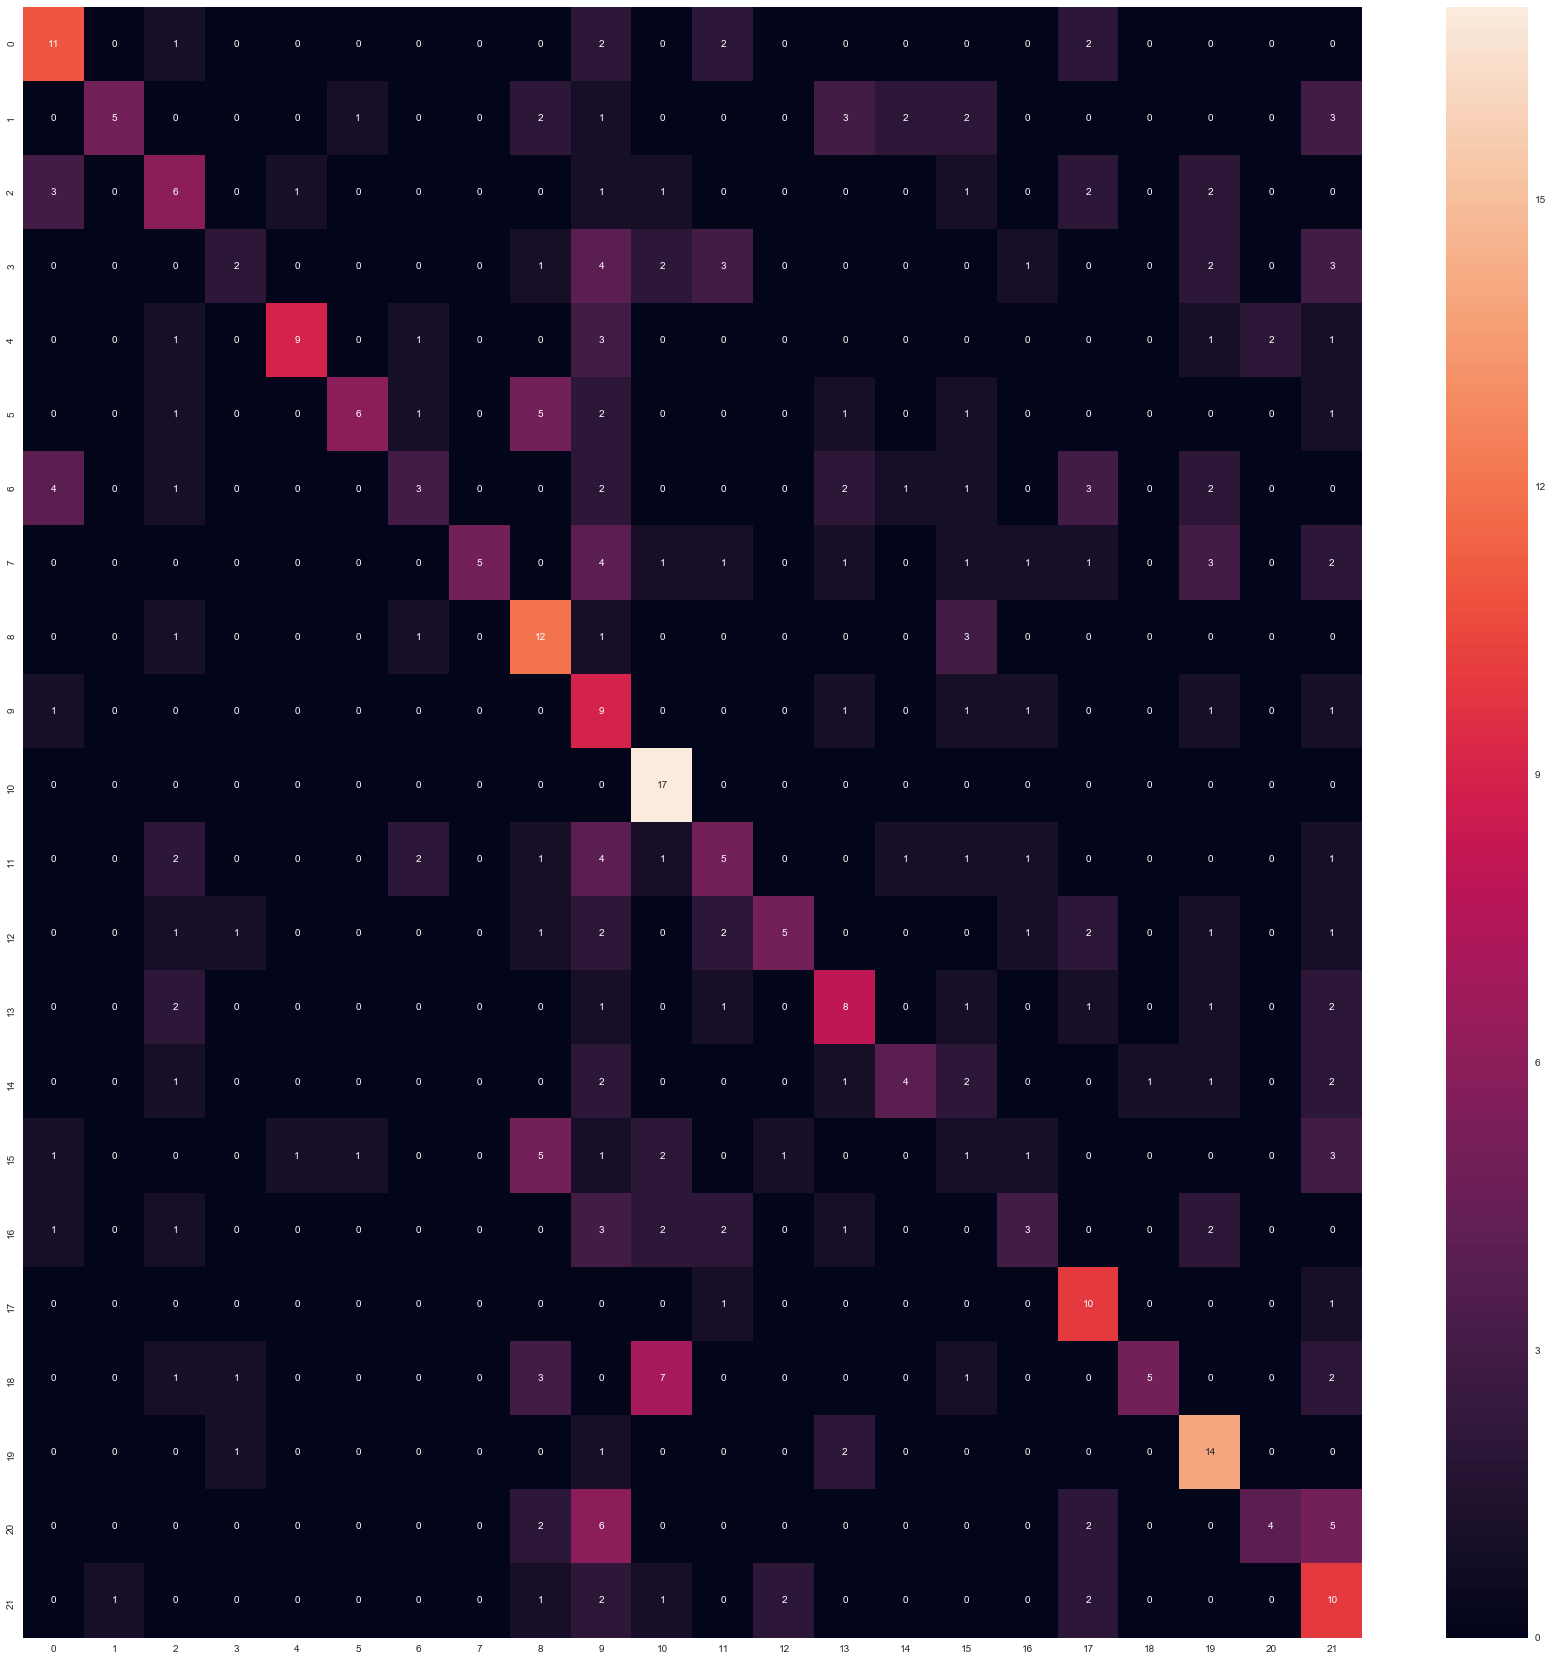

In [9]:
plt.figure(figsize=(30,30))
sns.heatmap(cm_task7, annot = True)

##### This model is less accurate as compared to the one in task5. The one in task 5 had much higher values on the diagonal.

## Task 8

Now you will explore another use of the deep features extracted in Task6. Content Based Image Retrieval (CBIR) is the task of searching for visually similar images from a dataset. *Think Google image search.* This concept can obviously be applied on other forms of data like text, audio or video as well. In this task you will:
- Implement a function which will take three inputs and returns a list of visually similar images. The inputs would be
> An image from the dataset `im` <br />
The number of search results to return `n` (no more than 5) <br />
A string representing the distance metric used for comparisons `dist`
- Visualize search result images, by looking for the appropriate image
- Use some images to compare the effects of these distance metrics on the output
> Euclidean <br />
Cosine <br />
Mahalanobis

*Make sure the query image is the first search result for your function*

*Look up the documentation for Scipy's `spatial.distance` module. It is your best friend in this task.*

*If you made a generator in Task6, you can very easily use it in this task as well*

In [14]:
paths_to_all_images_task8 = paths_to_all_images_task6
labels_to_all_images_task8 = labels_to_all_images_task6
len(labels_to_all_images_task8)

2159

In [15]:
def encoder_generator_part8(path_all_images, class_labels, batch_size = 64):
    total_pictures = len(path_all_images)
    
    indexes = np.arange(0,total_pictures,batch_size) #setting start index of each batch
    
    if total_pictures % batch_size != 0:
        indexes = indexes[:-1]  #dropping last index if last batch does not complete the batch size requirement

    while True:
        np.random.shuffle(indexes) #shuffles indexes so order of data given to model in each epoch is different
        for index in indexes:
            path = path_all_images[index : index + batch_size]
            labels = class_labels[index : index + batch_size]
            
            x_array = np.zeros((batch_size,256,256,3))
            batch_labels = to_categorical(labels, num_classes = 22)
            
            for i in range(batch_size):
                img = cv2.imread(path[i])
                x_array[i] = cv2.resize(img,(256,256))
                
            resized_images = x_array  
            labels = np.array(batch_labels)
            
            encoded_output = encoder_pretained.predict(resized_images,verbose=0)
            encoded_output_reshaped = np.reshape(encoded_output, (encoded_output.shape[0],
                                                                 encoded_output.shape[1]*encoded_output.shape[2],
                                                                 encoded_output.shape[3]))
        
            yield encoded_output_reshaped, path
        

In [22]:
def cbir(im, n, dist='Euclidean'):
    #get all images encoded versions
    #encode im
    #compute distance of all points
    #compare mean

    real_image_paths = []
    dist_each_point = []
    mean_distance_from_each_image = []
    sorted_indexes = []
    
    im_encoded = encoder_pretained.predict(im, verbose = 0)
    im_encoded = np.reshape(im_encoded, (im_encoded.shape[1]*im_encoded.shape[2],
                                        im_encoded.shape[3]))

    
    gen_task8 = encoder_generator_part8(paths_to_all_images_task8, labels_to_all_images_task8, 64)
    
    for i in range(len(paths_to_all_images_task8)//batch_size):
        encoded_image, real_image_path = next(gen_task8)
        for i in range(len(encoded_image)):
            if dist == 'Euclidean':
                dist =  cdist(im_encoded, encoded_image[i], 'euclidean')
            elif dist == 'Cosine':
                dist =  cdist(im_encoded, encoded_image[i], 'cosine')
            elif dist == 'Mahalanobis':
                dist =  cdist(im_encoded, encoded_image[i], 'mahalanobis', VI=None)   
            dist_each_point.append(dist)
            real_image_paths.append(real_image_path[i])
    
    dist_each_point = np.array(dist_each_point) #shape = (batchsize,64,64)
    
    for dist in dist_each_point:
        mean = np.mean(dist)
        mean_distance_from_each_image.append(mean)
        
    mean_distance_from_each_image = np.array(mean_distance_from_each_image) #shape = (batchsize,)
    
    if dist == 'Euclidean':
        sorted_indexes = np.argsort(mean_distance_from_each_image)
    elif dist == 'Cosine':
        sorted_indexes = np.argsort(-mean_distance_from_each_image)
    elif dist == 'Mahalanobis':
        sorted_indexes = np.argsort(mean_distance_from_each_image)
    
    #print im 
#     im = np.reshape(im, (256,256,3))
#     im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
#     plt.title("Query Image")
#     plt.imshow(im)
#     plt.show()
    
    #print closest n-images
    for i in range(n):
        paths = real_image_paths[sorted_indexes[i]]
        img = plt.imread(paths)
        plt.imshow(img)
        plt.show()


In [ ]:
im = cv2.imread(paths_to_all_images_task8[1])
im = np.reshape(im, (1,256,256,3))
                
cbir(im, 5,'Cosine')

